In [25]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import zipfile
import cv2
import gc # garbage collector
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

from warnings import filterwarnings
filterwarnings("ignore")

print(tf.__version__)

2.8.0


In [10]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [24]:
file_path = "/content/drive/MyDrive/FaceMask/data"
!ls "/content/drive/MyDrive/FaceMask/data"

data_preprocess.npz  Mask  Mask_Chin  Mask_Mouth_Chin  Mask_Nose_Mouth


In [17]:
zip_file = zipfile.ZipFile(file = os.path.join(file_path,"data_preprocess.npz"),mode = "r")
zip_file.extractall()
zip_file.close()

# Collect All Data & Labelling

In [28]:
dirs = os.listdir(file_path) 
dirs.pop(0)
print(dirs)

['Mask_Nose_Mouth', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask']


In [32]:
images_path = []
labels = []
for folder in dirs:
    path = glob(f"{file_path}/{folder}/*.jpg")
    label = [f"{folder}"]*len(path)
    #append
    images_path.extend(path)
    labels.extend(label)

In [33]:
len(images_path),len(labels)

(10000, 10000)

# Face Detection

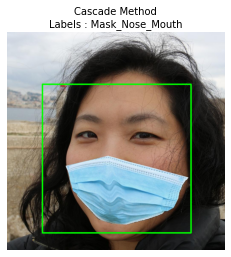

In [58]:
i = 0
selected_image = cv2.imread(images_path[i])
selected_labels = labels[i]

path = "/content/drive/MyDrive/OpenCV_Models/Cascades/haarcascade_frontalface_default.xml"
face_detector = cv2.CascadeClassifier(path)
detection = face_detector.detectMultiScale(cv2.cvtColor(selected_image,cv2.COLOR_BGR2GRAY))
cv2.rectangle(selected_image,detection[0],(0,255,0),5)

plt.figure(figsize = (4,4))
plt.imshow(cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB))
plt.title("Cascade Method\nLabels : {}".format(selected_labels),fontsize = 10)
plt.axis("off")
plt.show()

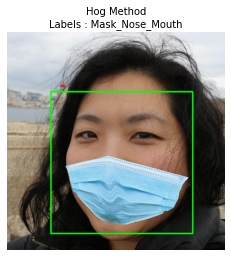

In [59]:
import dlib

i = 0
selected_image = cv2.imread(images_path[i])
selected_labels = labels[i]

# HOG
face_detector_hog = dlib.get_frontal_face_detector()
detection = face_detector_hog(selected_image,1)

for face in detection:
    l,t,r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(selected_image,(l,t), (r,b), (0,255,0), 5)

plt.figure(figsize = (4,4))
plt.imshow(cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB))
plt.title("Hog Method\nLabels : {}".format(selected_labels),fontsize = 10)
plt.axis("off")
plt.show()

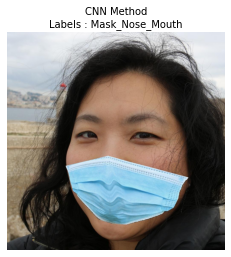

In [65]:
import dlib

i = 0
selected_image = cv2.imread(images_path[i])
selected_labels = labels[i]

# CNN 
# We need to use gpu for this detections
detect = False
if detect:
    path = "/content/drive/MyDrive/OpenCV_Models/Weights/mmod_human_face_detector.dat"
    face_detector_hog = dlib.cnn_face_detection_model_v1(path)
    #detection = face_detector_hog(selected_image,1)

    for face in detection:
        l,t,r,b,c = face.rect.left(), face.rect.top(), face.rect.right(), face.rect.bottom(),face.confidence
        print(c)
        cv2.rectangle(selected_image,(l,t), (r,b), (0,255,0), 5)

plt.figure(figsize = (4,4))
plt.imshow(cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB))
plt.title("CNN Method\nLabels : {}".format(selected_labels),fontsize = 10)
plt.axis("off")
plt.show()

In [68]:
!ls /content/drive/MyDrive/FaceMask/models

deploy.prototxt.txt  res10_300x300_ssd_iter_140000_fp16.caffemodel  urls.txt


In [70]:
file_models = "/content/drive/MyDrive/FaceMask/models"
face_detection_model = cv2.dnn.readNetFromCaffe(os.path.join(file_models,"deploy.prototxt.txt"),
                                                os.path.join(file_models,"res10_300x300_ssd_iter_140000_fp16.caffemodel"))

Blob Shape : (1, 3, 300, 300)
Detection Shape : (1, 1, 200, 7)


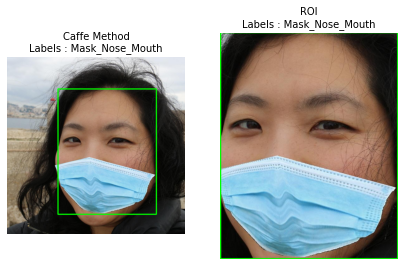

In [81]:
i = 0
selected_image = cv2.imread(images_path[i])
selected_labels = labels[i]

# blob from image (RGB mean subtraction image)
h,w = selected_image.shape[:2]
blob = cv2.dnn.blobFromImage(selected_image,1,(300,300),(104,117,123),swapRB = True)
print("Blob Shape : {}".format(blob.shape) )
# get the detections
face_detection_model.setInput(blob)
detections = face_detection_model.forward()
print("Detection Shape : {}".format(detections.shape))

for i in range(0,detections.shape[2]):
    confidence = detections[0,0,i,2] # confidence
    if confidence > 0.5:
        # Normalize 
        box = detections[0,0,i,3:7]*np.array([w,h,w,h])
        box = box.astype(int)

        pt1 = (box[0],box[1])
        pt2 = (box[2],box[3])
        cv2.rectangle(selected_image,pt1,pt2,(0,255,0),5)

roi = selected_image[box[1]:box[3],box[0]:box[2]] 

plt.figure(figsize = (7,7))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB))
plt.title("Caffe Method\nLabels : {}".format(selected_labels),fontsize = 10)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title("ROI\nLabels : {}".format(selected_labels),fontsize = 10)
plt.axis("off")

plt.show()

In [85]:
!ls /content/drive/MyDrive/FaceMask/models

deploy.prototxt.txt  res10_300x300_ssd_iter_140000_fp16.caffemodel  urls.txt


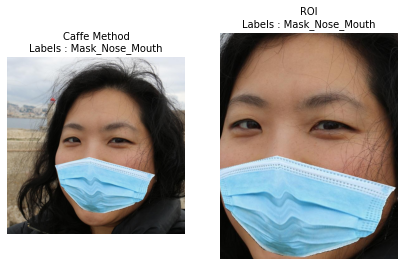

In [89]:
import cv2 
file_models = "/content/drive/MyDrive/FaceMask/models"
face_detection_model = cv2.dnn.readNetFromCaffe(os.path.join(file_models,"deploy.prototxt.txt"),
                                                 os.path.join(file_models,"res10_300x300_ssd_iter_140000_fp16.caffemodel"))

def face_detection_dnn(image):
    # blob from image (rgb mean subtraction image)
    image_ = image.copy()
    h,w = image_.shape[:2]
    blob = cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB = True)

    # get detections
    face_detection_model.setInput(blob)
    detections = face_detection_model.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2] #confidence score
        if confidence > 0.5:
            bbox = detections[0,0,i,3:7]*np.array([w,h,w,h])
            bbox = bbox.astype(int)

            pt1 = (bbox[0],bbox[1])
            pt2 = (bbox[2],bbox[3])
            roi = image_[bbox[1]:bbox[3],bbox[0]:bbox[2]]

            return roi
    return None

i = 0
selected_image = cv2.imread(images_path[i])
selected_labels = labels[i]

image_roi = face_detection_dnn(selected_image)

plt.figure(figsize = (7,7))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB))
plt.title("Caffe Method\nLabels : {}".format(selected_labels),fontsize = 10)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(image_roi, cv2.COLOR_BGR2RGB))
plt.title("ROI\nLabels : {}".format(selected_labels),fontsize = 10)
plt.axis("off")

plt.show()

In [126]:
def datapreprocess(image):
    face = face_detection_dnn(image)
    if face is not None:

        blob = cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB = True)
        blob_squeeze = np.squeeze(blob).T
        blob_rotate = cv2.rotate(blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
        blob_flip = cv2.flip(blob_rotate,1)

        img_norm = np.maximum(blob_flip,0)/blob_flip.max()
        return img_norm

    else:
        return None

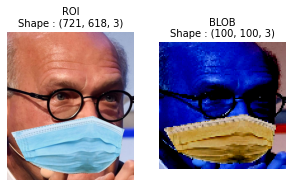

In [127]:
i = 5
selected_image= cv2.imread(images_path[i])
roi_face= face_detection_dnn(selected_image)

image_norm = datapreprocess(selected_image)

def convert_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (5,5))
plt.subplot(1,2,1)
plt.imshow(convert_rgb(roi_face))
plt.title(f"ROI\nShape : {roi_face.shape}",fontsize = 10)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(convert_rgb(image_norm))
plt.title(f"BLOB\nShape : {image_norm.shape}",fontsize = 10)
plt.axis("off")

plt.show()

# Apply To All Image And Append In A List

In [131]:
len(images_path),len(labels)

(10000, 10000)

In [132]:
data_img = []
label_img = []
i = 0

for path,label in tqdm(zip(images_path,labels),desc = "preprocessing"):
    img = cv2.imread(path)
    process_img = datapreprocess(img)
    if process_img is not None:
        data_img.append(process_img)
        label_img.append(label)
        
    i+=1
    if  i%100 == 0:
        gc.collect()

preprocessing: 10000it [1:02:40,  2.66it/s]


In [133]:
X = np.array(data_img)
y = np.array(label_img)

X.shape,y.shape

((9959, 100, 100, 3), (9959,))

In [134]:
np.savez("/content/drive/MyDrive/FaceMask/data_preprocess",X,y)

In [135]:
!ls /content/drive/MyDrive/FaceMask/

'01- Data_Preparation&Preprocessing.ipynb'   data_preprocess.npz
 data					     models


# Train Deep Learning Model

In [1]:
import os 
import numpy as np
import cv2
import gc 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
data = np.load("/content/drive/MyDrive/FaceMask/data_preprocess.npz")
data.files

['arr_0', 'arr_1']

In [3]:
X = data["arr_0"]
y = data["arr_1"]

X.shape,y.shape

((9959, 100, 100, 3), (9959,))

In [4]:
np.unique(y,return_counts = True)

(array(['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth'],
       dtype='<U15'), array([2477, 2500, 2500, 2482]))

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [6]:
onehot = OneHotEncoder()
y_onehot = onehot.fit_transform(y.reshape(-1,1))
y_array = y_onehot.toarray()

y_array[:5]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [7]:
X.shape,y_array.shape

((9959, 100, 100, 3), (9959, 4))

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y_array,test_size = .2,random_state = 42)

In [9]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((7967, 100, 100, 3), (7967, 4), (1992, 100, 100, 3), (1992, 4))

In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = "relu",padding = "same", input_shape = (100,100,3)))
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units = 192,activation = "relu"))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Dense(units = 28,activation = "relu"))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Dense(units = 4,activation = "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        9248      
                                                        

In [11]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

In [12]:
history = model.fit(X_train,y_train,validation_data = (X_test,y_test),batch_size = 30,epochs = 50)

Epoch 1/50
266/266 [==============================] - 26s 50ms/step - loss: 0.4769 - accuracy: 0.8102 - val_loss: 0.1858 - val_accuracy: 0.9463
Epoch 2/50
266/266 [==============================] - 13s 50ms/step - loss: 0.1649 - accuracy: 0.9510 - val_loss: 0.1038 - val_accuracy: 0.9689
Epoch 3/50
266/266 [==============================] - 14s 53ms/step - loss: 0.1171 - accuracy: 0.9665 - val_loss: 0.1072 - val_accuracy: 0.9734
Epoch 4/50
266/266 [==============================] - 14s 53ms/step - loss: 0.1042 - accuracy: 0.9698 - val_loss: 0.0646 - val_accuracy: 0.9799
Epoch 5/50
266/266 [==============================] - 14s 52ms/step - loss: 0.0792 - accuracy: 0.9783 - val_loss: 0.1044 - val_accuracy: 0.9669
Epoch 6/50
266/266 [==============================] - 13s 50ms/step - loss: 0.0596 - accuracy: 0.9815 - val_loss: 0.0644 - val_accuracy: 0.9834
Epoch 7/50
266/266 [==============================] - 14s 53ms/step - loss: 0.0628 - accuracy: 0.9809 - val_loss: 0.0570 - val_accuracy:

In [45]:
def history_graph(history,epochs):

    plt.figure(figsize = (10,6))

    plt.subplot(121)
    plt.plot(history.history["accuracy"], label = "Train")
    plt.plot(history.history["val_accuracy"], label = "Validation")
    plt.legend(loc = "best")
    plt.title("Accuracy Score")
    plt.xticks(range(1,epochs+1,2),rotation = 90)

    plt.subplot(122)
    plt.plot(history.history["loss"], label = "Train")
    plt.plot(history.history["val_loss"], label = "Validation")
    plt.legend(loc = "best")
    plt.title("Loss Score")
    plt.xticks(range(1,epochs+1,2),rotation = 90)

    plt.tight_layout()
    plt.show()


def confusion_graph(y_test,y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize = (10,5))
    sns.heatmap(cm, annot = True, fmt = "d", cbar = False, linewidth = 0.4, linecolor = "white", annot_kws = {"size":20},
                xticklabels = ['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth'],
                yticklabels = ['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth'])
    plt.ylabel("Actual" ,fontsize = 10)
    plt.xlabel("Predicted" ,fontsize = 10)
    plt.title("Confusion Matrix Graph" ,fontsize = 10)
    plt.show()

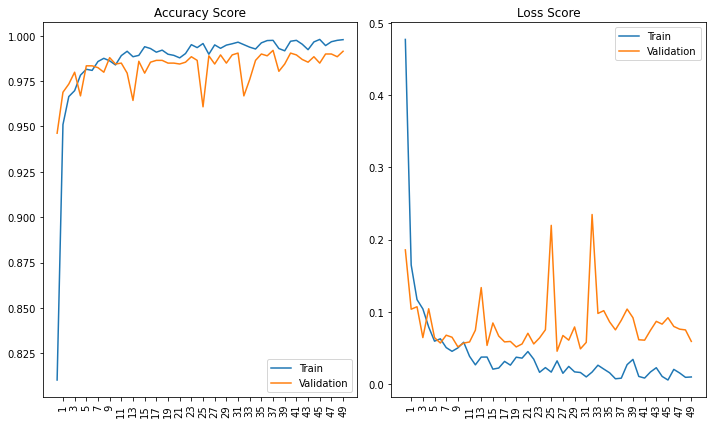

In [46]:
history_graph(history,epochs = 50)

In [17]:
test_loss,test_accuracy = model.evaluate(X_test,y_test)
print("Test Loss : {}".format(test_loss))
print("Test Accuracy : {}".format(test_accuracy))

63/63 [==============================] - 2s 25ms/step - loss: 0.0593 - accuracy: 0.9915
Test Loss : 0.05926964804530144
Test Accuracy : 0.9914658665657043


In [26]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis = 1)
y_pred[:5]

array([1, 0, 2, 1, 2])

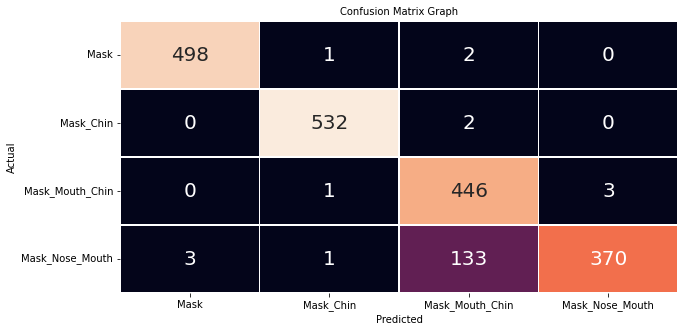

In [47]:
confusion_graph(np.argmax(y_test,axis=1),
                y_pred)

In [31]:
from sklearn.metrics import classification_report,accuracy_score

print("Classification Reports : ")
print(classification_report(np.argmax(y_test,axis=1),
                y_pred))
print()
print("Accuracy Score : ")
print(accuracy_score(np.argmax(y_test,axis=1),
                y_pred))

Classification Reports : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       501
           1       0.99      1.00      1.00       534
           2       0.77      0.99      0.86       450
           3       0.99      0.73      0.84       507

    accuracy                           0.93      1992
   macro avg       0.94      0.93      0.92      1992
weighted avg       0.94      0.93      0.93      1992


Accuracy Score : 
0.9267068273092369


In [32]:
mask_model_json= model.to_json()
with open("mask_model_50.json","w") as json_file:
    json_file.write(mask_model_json)

In [33]:
tf.keras.models.save_model(model,"mask_model_50.h5")

In [35]:
with open("mask_model_50.json", "r") as json_file:
    load_model_json = json_file.read()
json_file.close()

In [38]:
load_model = tf.keras.models.model_from_json(load_model_json)
load_model.load_weights("mask_model_50.h5")

load_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ["accuracy"])

load_model.evaluate(X_test,y_test)

63/63 [==============================] - 2s 23ms/step - loss: 0.0593 - accuracy: 0.9915


[0.05926964804530144, 0.9914658665657043]

In [39]:
print("Test Loss : {}".format(test_loss))
print("Test Accuracy : {}".format(test_accuracy))

Test Loss : 0.05926964804530144
Test Accuracy : 0.9914658665657043


In [44]:
model.save("/content/drive/MyDrive/FaceMask/mask_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FaceMask/mask_model/assets


In [40]:
from google.colab import files
files.download("mask_model_50.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
files.download("mask_model_50.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("mask_model")